# Imports

In [75]:
#General
import os as os
from os.path import join
from google.colab import drive
from PIL import Image, ImageFilter
!pip install cairosvg
import cairosvg
import glob
import cv2
from google.colab.patches import cv2_imshow
import shutil
import warnings
from types import SimpleNamespace
from tqdm import tqdm
import math
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display

import numpy as np
from numpy import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# PyTorch components
import torchvision
from torchvision import datasets
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim

#Fen to Chessboard image
!pip install fenToBoardImage
from fentoboardimage import fenToImage, loadPiecesFolder

# Dataset initialization

## Creating the .png from .svg files

Let's convert the .svg files to .png

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets/"

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0]
    # Convert SVG to PNG
    try:
      cairosvg.svg2png(url=os.path.join(specific_folder,image), write_to=os.path.join(specific_folder,name+'.png'))
    except Exception as e:
      print(e)

Mounted at /content/gdrive
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0


Then i need to delete the .svg files since i will not need them anymore

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"
#specific pattern to eliminate
file_pattern = '*.svg'

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  full_pattern = os.path.join(specific_folder, file_pattern)
  for svg in glob.glob(full_pattern):
    try:
        os.remove(svg)  # Delete the file
    except Exception as e:
        print(f"Error deleting {full_pattern}: {e}")

Mounted at /content/gdrive


The next thing to do is to take a look inside the folders in order to check if some of the pieces are too weirdly shaped to be part of a training/testing set.

## Pieces shape check and removal

In the following i wrote the folder names that need to be evaluated before moving on with the project.

In [ ]:
to_remove = ["anarcandy",    #too weirdly shaped
             "disguised",   #too weirdly shaped
             "horsey",      #too weirdly shaped
             "kiwen-suwi",   #too weirdly shaped, knights are the other way around
             "letter",      #too weirdly shaped
             "mono",        #monochromatic
             "reillycraig", #too small
             "shapes"]      #too weirdly shaped

maybe_remove = ["dubrovny",     #pieces have different color
                "caliente",     #too small
                "fantasy",      #too weirdly shaped
                "leipzig",      #too weirdly shaped
                "monarchy",     #too weirdly shaped
                "piruetti",     #no edges around images
                "pixel",        #too small, too weirdly shaped
                "spatial"]      #too weirdly shaped

Let's take a better look at the to_remove and maybe remove piece sets.

If it gives error use
```
drive.flush_and_unmount()
drive.mount('/content/drive')
```
Insted of
```
drive.mount('/content/gdrive',force_remount=True)
```




Mounted at /content/gdrive
Folder:anarcandy


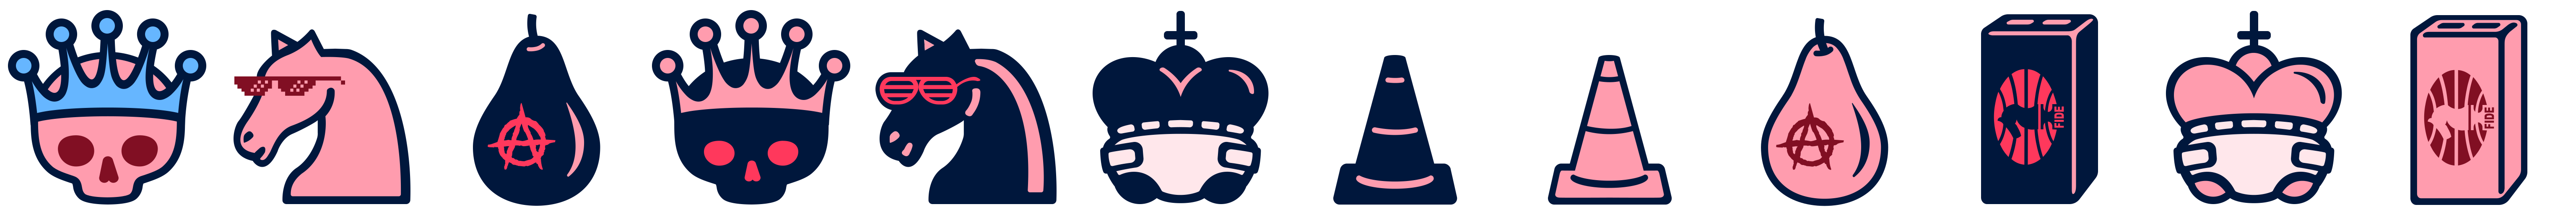


Folder:disguised


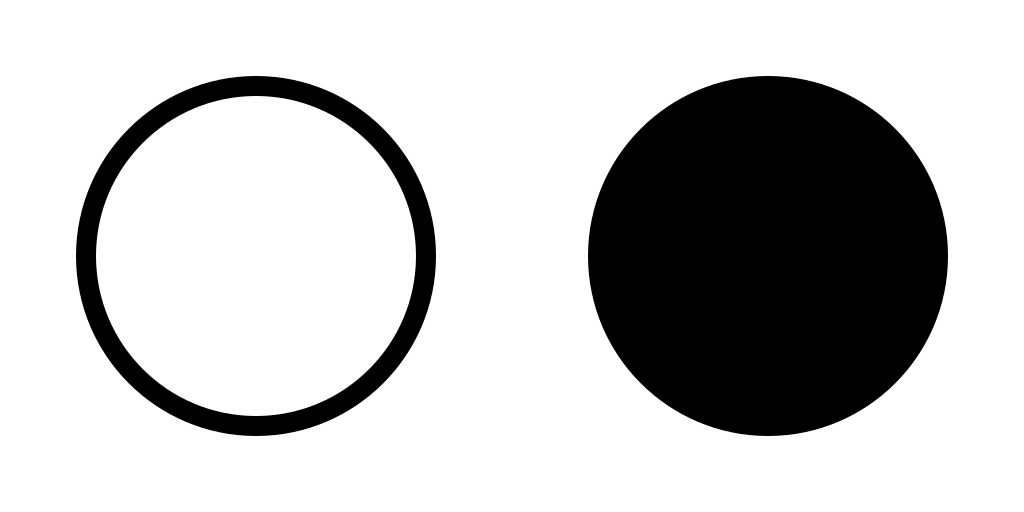


Folder:kiwen-suwi


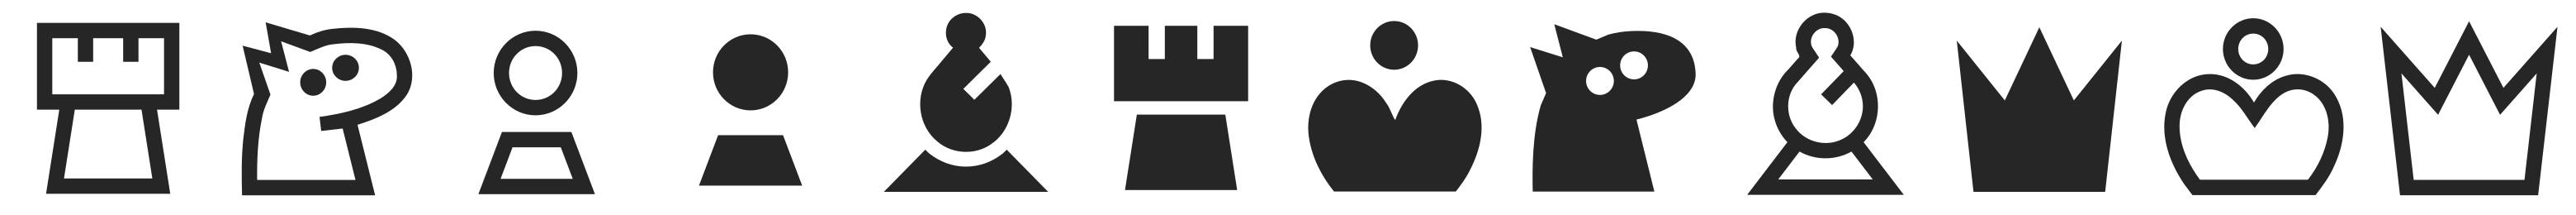


Folder:horsey


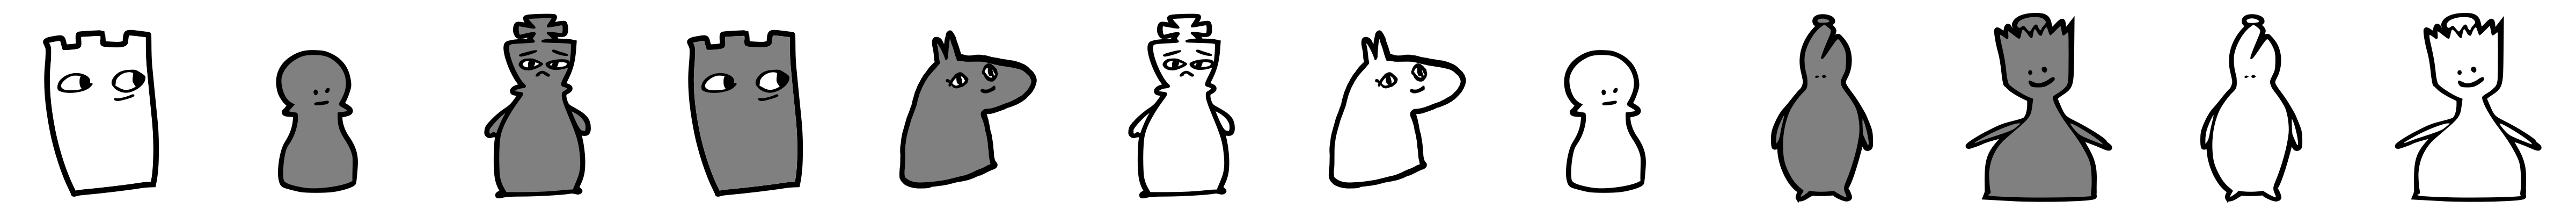


Folder:letter


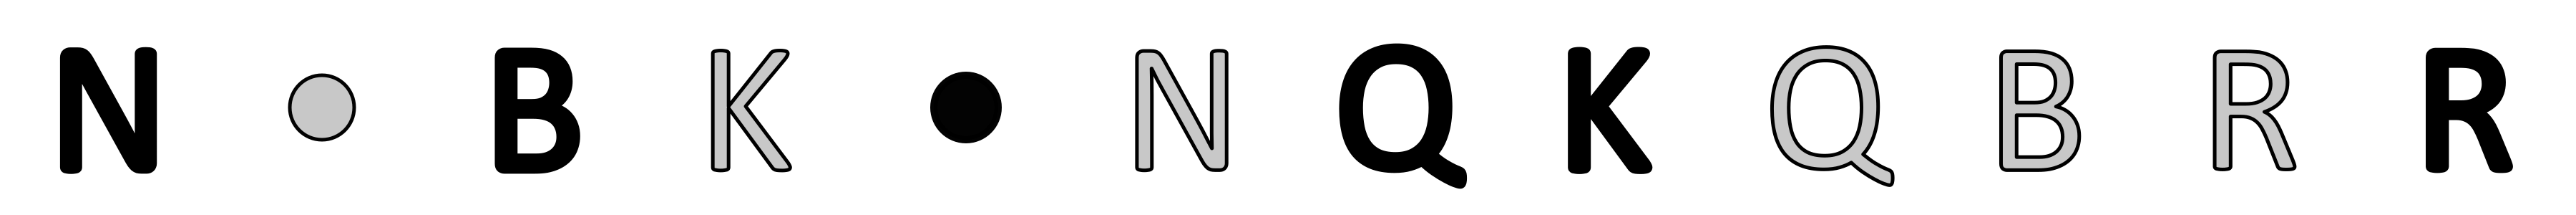


Folder:mono


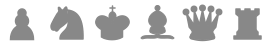


Folder:reillycraig



Folder:shapes


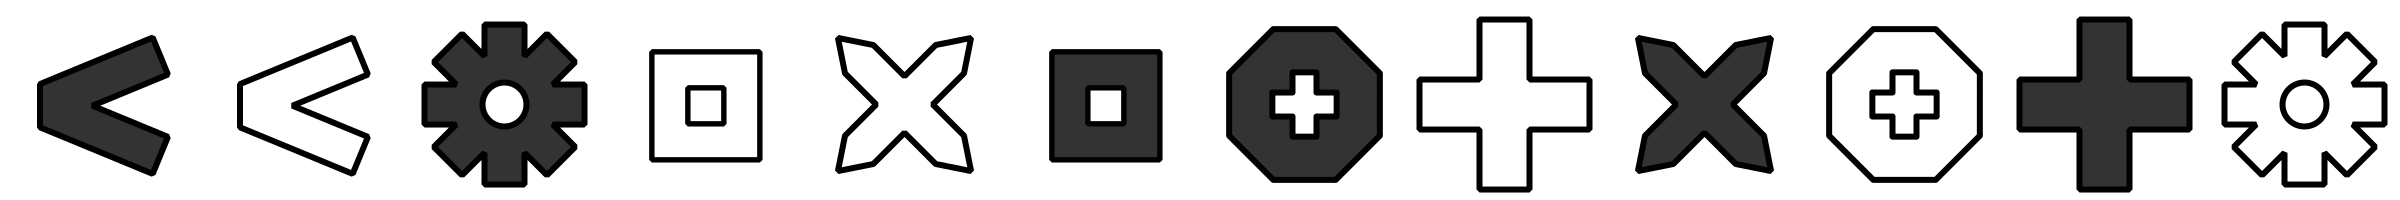

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
# drive.flush_and_unmount()
# drive.mount('/content/drive')
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"

remove = []

for folder in os.listdir(path):
  if folder in to_remove:
    specific_folder = os.path.join(path, folder)
    print(f"Folder:{folder}")
    for image in os.listdir(specific_folder):
      img = cv2.imread(os.path.join(specific_folder, image), cv2.IMREAD_UNCHANGED)
      remove.append(img)

    cv2_imshow(cv2.hconcat(remove))
    remove = []
    print()


If it gives error use
```
drive.flush_and_unmount()
drive.mount('/content/drive')
```
Insted of
```
drive.mount('/content/gdrive',force_remount=True)
```

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
# drive.flush_and_unmount()
# drive.mount('/content/drive')
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"

remove = []

for folder in os.listdir(path):
  if folder in maybe_remove:
    specific_folder = os.path.join(path, folder)
    print(f"Folder:{folder}")
    for image in os.listdir(specific_folder):
      img = cv2.imread(os.path.join(specific_folder, image), cv2.IMREAD_UNCHANGED)
      remove.append(img)

    cv2_imshow(cv2.hconcat(remove))
    remove = []
    print()

Output hidden; open in https://colab.research.google.com to view.

Let's eliminate the to_remove folders before stepping into the next part of the project.

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"

for folder in os.listdir(path):
  if folder in to_remove:
    specific_folder = os.path.join(path, folder)
    shutil.rmtree(specific_folder)

Mounted at /content/gdrive


## Applying backgrounds to the pngs

I need to set different background colors for each of my .pgn in order to emulate the possible different Lichess boards and expose the model to not just the pieces shapes. I will need to create a lighter version, as well as a darker one, just like on the board.

In [ ]:
color_scheme = [(218, 166, 113), #light brown
                (146, 116, 84),  #dark brown
                (214, 245, 255), #light cyan
                (153, 210, 229), #dark cyan
                (194, 255, 194), #light green
                (155, 217, 155), #dark green
                (222, 222, 222), #light grey
                (148, 148, 148), #dark grey
                (186, 156, 196), #light purple
                (164, 108, 183)  #dark purple
                ]

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN"
cont = 0

try:
  #grouped pieces folder
  os.mkdir(f'{path}/Grouped_Pieces')
  #pieces folders
  os.mkdir(f'{path}/Grouped_Pieces/0.Pawns')
  os.mkdir(f'{path}/Grouped_Pieces/1.Knights/')
  os.mkdir(f'{path}/Grouped_Pieces/2.Bishops/')
  os.mkdir(f'{path}/Grouped_Pieces/3.Rooks/')
  os.mkdir(f'{path}/Grouped_Pieces/4.Queens/')
  os.mkdir(f'{path}/Grouped_Pieces//5.Kings/')
  os.mkdir(f'{path}/Grouped_Pieces/6.Empty/')
except FileExistsError:
    print("Grouped folders already exist!")

path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"
for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    # Open the existing PNG image
    im = Image.open(os.path.join(specific_folder,image))
    # Define the new background color (RGB format)
    for color in color_scheme:
      new_im = im.convert("RGBA")
      # Create a new image with the same size and the desired background color in RGB mode
      background = Image.new("RGB", im.size, color)
      # Paste the original image on top of the background, using its alpha channel as a mask
      background.paste(im, (0, 0), new_im)
      name = image.split(sep=".")[0]
      match name:
        case "bP" | "wP":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/0.Pawns/{name}{cont}.png")
        case "bN" | "wN":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/1.Knights/{name}{cont}.png")
        case "bB" | "wB":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/2.Bishops/{name}{cont}.png")
        case "bR" | "wR":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/3.Rooks/{name}{cont}.png")
        case "bQ" | "wQ":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/4.Queens/{name}{cont}.png")
        case "bK" | "wK":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/5.Kings/{name}{cont}.png")
      cont += 1

Mounted at /content/gdrive


In [ ]:
def create_random_solid_color_image(height, width):
    random_color = np.random.randint(0, 256, size=3)

    # Create a blank image and fill it with the random color.
    image = np.zeros((height, width, 3), dtype=np.uint8)
    image[:, :] = random_color

    return image

In [ ]:
#Generating empty squares
for _ in range(0,250):
  empty_square = create_random_solid_color_image(100, 100)
  cv2.imwrite(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/6.Empty/empty{cont}.png", empty_square)
  cont += 1
  #cv2_imshow(empty_square)

## Checking the images dimensions distribution

In [ ]:
pieces = pd.DataFrame(columns=["Piece","Path","Dimension"])

drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/"

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0]
    img = Image.open(os.path.join(specific_folder,image))
    width, height = img.size
    dimension = str(width) + "x" + str(height)

    if "empty" in name: name = "Empty"
    elif "P" in name: name = "Pawn"
    elif "N" in name: name = "Knight"
    elif "B" in name: name = "Bishop"
    elif "R" in name: name = "Rook"
    elif "Q" in name: name = "Queen"
    elif "K" in name: name = "King"

    pieces.loc[len(pieces)] = [name,os.path.join(specific_folder,image),dimension] #adding elements at the end of my DataFrame

Mounted at /content/gdrive


In [ ]:
pieces["Piece"] = pieces['Piece'].astype(str)
pieces["Path"] = pieces['Path'].astype(str)
pieces["Dimension"] = pieces['Dimension'].astype(str)

<Axes: >

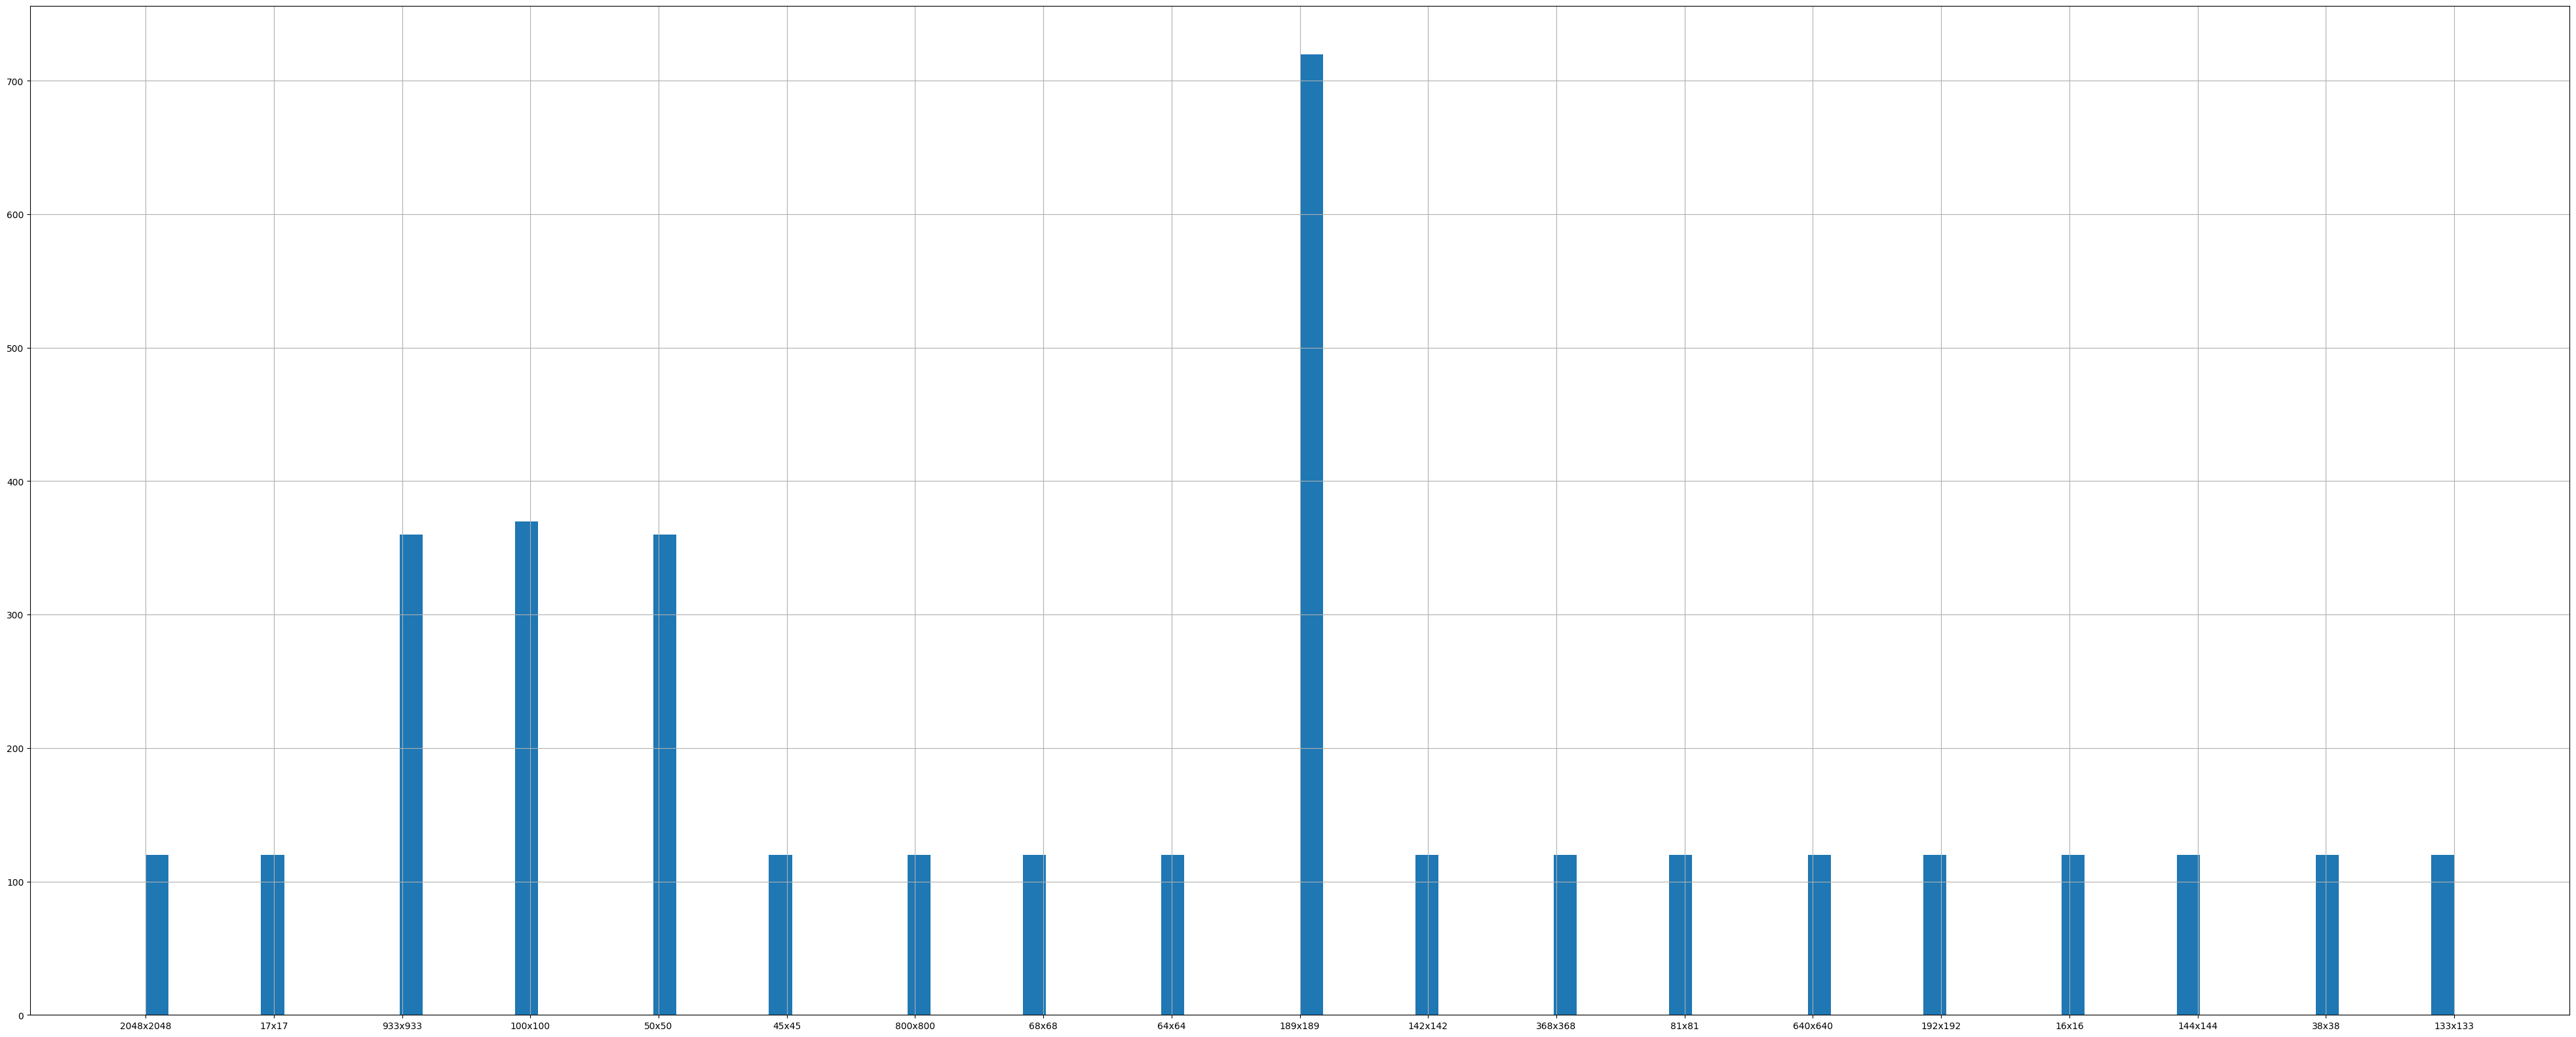

In [ ]:
#pieces["Dimension"].loc[(pieces["Piece"] == "Pawn")].hist(figsize=(50,20), bins=50)
pieces["Dimension"].hist(figsize=(50,20), bins=100)

As we can see we have a wide dimensionality range.

CNN works by training and testing on images that have the same dimensionality so we need to make some adjustments.

I need to scale all the images to have the same dimensionality, and then delete the ones the are too raw to be useful.

I run a test by screenshotting some chess positions from youtube, lichess and chess.com and the resulting resolutions are:
- lichess.org: 704x711
- chess.com: 868x876
- youtube fullscreen: 1062x1060
- youtube ***not*** fullscreen: 681x697

From which we get, more or less depending on the quality of the screenshot taken, the following ***single cell resolutions***:
- lichess.org: 88x88
- chess.com: 110x110
- youtube fullscreen: 132x130
- youtube ***not*** fullscreen: 82x86

Given these informations i think that **100x100** (close to the mean value) should be the best dimensionality to scale ***each training and test image***.
The entire chessboard screenshot should then be scaled to **800x800**.

## Dataset cleaning and visualization

Let's start by deleting all the images that are too small (approximately the ones smaller than 50x50), since they are impossible to be recognized after applying blur+noise+ even from a human. I might consider applying blur+noise after the resize in order to not lose instances.

In [ ]:
# print("Pieces with dimension 1x1: " + str(pieces["Path"].loc[pieces["Dimension"] == "1x1"].sum()))

# for path in pieces["Path"].loc[pieces["Dimension"] == "1x1"]:
#   os.remove(path)
#   pieces.drop(pieces[pieces['Path'] == path].index, inplace=True)

# print("[CHECK AFTER DELETE] Pieces with dimension 1x1 remaining: " + str(pieces["Path"].loc[pieces["Dimension"] == "1x1"].sum()))

Let's run a test and see the resulting images after resing them to 100x100.

In [ ]:
new_images = []
cont = 0

for path in pieces["Path"]:
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  new_dimensions = (100,100)
  resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA)
  new_images.append(resized_img)
  if cont >= 17:
    cv2_imshow(cv2.hconcat(new_images))
    new_images = []
    cont = 0
  else:
    cont += 1

Output hidden; open in https://colab.research.google.com to view.

The results seem pretty good even for the low quality pieces, therefore i am going to keep them in order to expose the model i'm training to some low quality ones.

## Changing the pieces dimensionality related to the test size

The main idea is that i need to have a screenshot whose single cell dimensionality matches the dimensionality of the pieces i trained on. Therefore i need to make the pieces all the same dimension, then multiply each of their dimension by 8. **This result will be the dimensionality i need to set my screenshot to**, so that by diving it into 64 squared, each and every one will match the pieces size i trained on. As said before, i would like to set the dimensionality of each piece to be **100x100**.

1. random piece width = x, random piece height = y
2. scaled piece width = x' -> 100, scaled piece height = y' -> 100
3. scaled screenshot width = x' * 8, scaled screenshot height = y' * 8
4. scaled single cell screenshot width = x' -> 100, scaled single cell screenshot height = y' -> 100

In [ ]:
#rescale each image to have dimensionality 100x100
for path in pieces["Path"]:
  img = cv2.imread(path)
  new_dimensions = (100,100)
  resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA) #this type of interpolation tries to keep the quality when upscaling/downscaling
  filename = path.split("/")[-1] #just take the {name}.pgn
  cv2.imwrite(path, resized_img) #overwrite the existing images with the resized ones

Last but not least i need to apply noise into my images in order to better generalize during the training phase.

***(I don't need to do it anymore since i apply this process in the transformation part during training, saving a ton of space)***

In [ ]:
# def add_gaussian_noise(image, mean, std):
#     noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
#     noisy_image = cv2.add(image, noise)
#     return noisy_image

# drive.mount('/content/gdrive',force_remount=True)
# path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces"
# new_images = []
# cont = 0

# for folder in os.listdir(path):
#   specific_folder = os.path.join(path, folder)
#   for image in os.listdir(specific_folder):
#     im = os.path.join(specific_folder,image)
#     im1 = cv2.imread(im)
#     blurred_image = cv2.blur(im1, (int(np.random.uniform(low=2, high=10)),int(np.random.uniform(low=2, high=10))))
#     noisy_image = add_gaussian_noise(blurred_image, mean=np.random.uniform(low=.1, high=.5), std=np.random.uniform(low=.4, high=1.4))
#     #cv2_imshow(noisy_image)
#     cv2.imwrite(im, noisy_image)
#     new_images.append(noisy_image)
#     if cont >= 17:
#       cv2_imshow(cv2.hconcat(new_images))
#       new_images = []
#       cont = 0
#     else:
#       cont += 1

# From images to tensors

The dataset must be organized in this way in order to use DataLoader by pytoch:

```
dataset/
    train/
        class_1/
            img1.jpg
            img2.jpg
        class_2/
            img1.jpg
            img2.jpg
    test/
        class_1/
            img1.jpg
        class_2/
            img1.jpg
```
Since i have 13 classes i need to name each folder as such:
```
00.class_0
01.class_1
...
13.class_13
```
or else the DataLoader and ImageFolder would highly mess up the labeling of the instances since their indexes would be:
```
0.class_0
1.class_1
10.class_10 (seen as class_2)
11.class_11 (seen as class_3)
12.class_12 (seen as class_4)
13.class_13 (seen as class_5)
2.class_2 (seen as class_6)
...
```

## Train/Validation/Test classes creation

I want to create a DataFrame containing each of my piece and its path. I will then apply *train_test_split* from scikit learn to randomly permute it and split it into train and test. The creation of the folders and insertion of each piece inside the correct one will then be straighforward.

In [ ]:
#DataFrame creation

drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/"


dataset = pd.DataFrame(columns=["Piece","Path"])
for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0][0:2] #i take into account just the first 2 letters (color + piece)
    match name:
      case "wP":
        dataset.loc[len(dataset)] = ["WhitePawn",str(os.path.join(specific_folder, image))]
      case "bP":
        dataset.loc[len(dataset)] = ["BlackPawn",str(os.path.join(specific_folder, image))]
      case "wN":
        dataset.loc[len(dataset)] = ["WhiteKnight",str(os.path.join(specific_folder, image))]
      case "bN":
        dataset.loc[len(dataset)] = ["BlackKnight",str(os.path.join(specific_folder, image))]
      case "wB":
        dataset.loc[len(dataset)] = ["WhiteBishop",str(os.path.join(specific_folder, image))]
      case "bB":
        dataset.loc[len(dataset)] = ["BlackBishop",str(os.path.join(specific_folder, image))]
      case "wR":
        dataset.loc[len(dataset)] = ["WhiteRook",str(os.path.join(specific_folder, image))]
      case "bR":
        dataset.loc[len(dataset)] = ["BlackRook",str(os.path.join(specific_folder, image))]
      case "wQ":
        dataset.loc[len(dataset)] = ["WhiteQueen",str(os.path.join(specific_folder, image))]
      case "bQ":
        dataset.loc[len(dataset)] = ["BlackQueen",str(os.path.join(specific_folder, image))]
      case "wK":
        dataset.loc[len(dataset)] = ["WhiteKing",str(os.path.join(specific_folder, image))]
      case "bK":
        dataset.loc[len(dataset)] = ["BlackKing",str(os.path.join(specific_folder, image))]
      case "em":
        dataset.loc[len(dataset)] = ["Empty",str(os.path.join(specific_folder, image))]

#65% train, (35% test -> 17.5% test, 17.5% validation)
train_dataset,test_dataset = train_test_split(dataset, test_size=.35, random_state=150) #the validation set will be created later on

Mounted at /content/gdrive


Let's take a look at the train and test pieces distributions before creating the folders. I would like to have a train instances distribution that is as close as possible to a uniform distribution.

Text(0.5, 1.0, 'Train pieces distribution (2346 pieces)')

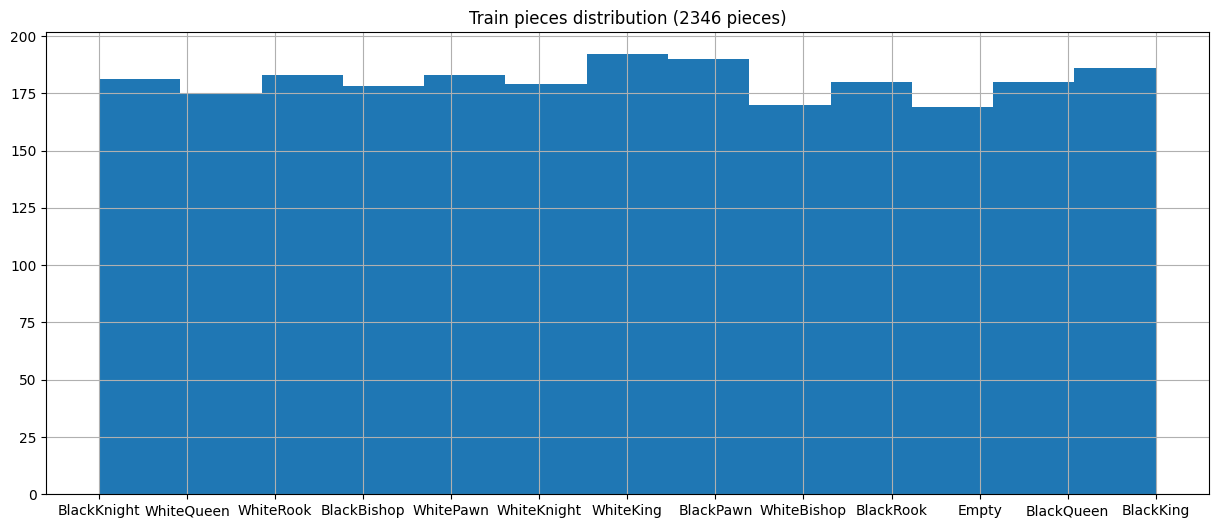

In [ ]:
train_dataset["Piece"].hist(figsize=(15,6),bins=13).set_title(f"Train pieces distribution ({len(train_dataset)} pieces)")

Text(0.5, 1.0, 'Test pieces distribution (1264 pieces)')

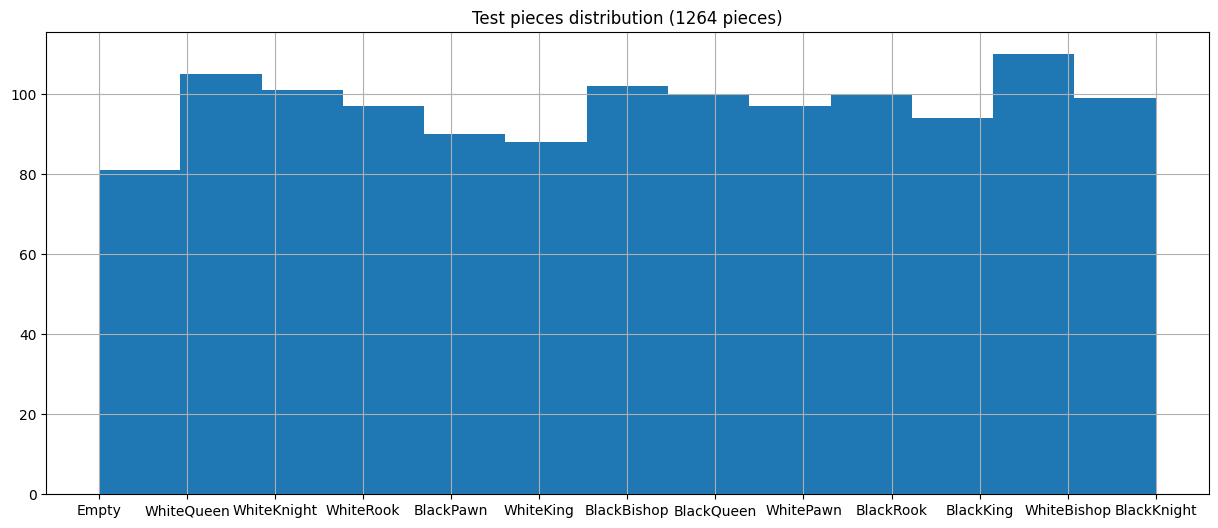

In [ ]:
test_dataset["Piece"].hist(figsize=(15,6),bins=13).set_title(f"Test pieces distribution ({len(test_dataset)} pieces)")

## Default DataLoader path creation and folder population

In [ ]:
#Folders creation

drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN"

try:
  #dataset folder
  os.mkdir(f'{path}/dataset/')
  #train folder
  os.mkdir(f'{path}/dataset/train')
  #train classes
  os.mkdir(f'{path}/dataset/train/00wP')
  os.mkdir(f'{path}/dataset/train/01bP')
  os.mkdir(f'{path}/dataset/train/02wN')
  os.mkdir(f'{path}/dataset/train/03bN')
  os.mkdir(f'{path}/dataset/train/04wB')
  os.mkdir(f'{path}/dataset/train/05bB')
  os.mkdir(f'{path}/dataset/train/06wR')
  os.mkdir(f'{path}/dataset/train/07bR')
  os.mkdir(f'{path}/dataset/train/08wQ')
  os.mkdir(f'{path}/dataset/train/09bQ')
  os.mkdir(f'{path}/dataset/train/10wK')
  os.mkdir(f'{path}/dataset/train/11bK')
  os.mkdir(f'{path}/dataset/train/12em')
except FileExistsError:
    print("Train folders already exist!")

try:
  #test folder
  os.mkdir(f'{path}/dataset/test')
  #test classes
  os.mkdir(f'{path}/dataset/test/00wP')
  os.mkdir(f'{path}/dataset/test/01bP')
  os.mkdir(f'{path}/dataset/test/02wN')
  os.mkdir(f'{path}/dataset/test/03bN')
  os.mkdir(f'{path}/dataset/test/04wB')
  os.mkdir(f'{path}/dataset/test/05bB')
  os.mkdir(f'{path}/dataset/test/06wR')
  os.mkdir(f'{path}/dataset/test/07bR')
  os.mkdir(f'{path}/dataset/test/08wQ')
  os.mkdir(f'{path}/dataset/test/09bQ')
  os.mkdir(f'{path}/dataset/test/10wK')
  os.mkdir(f'{path}/dataset/test/11bK')
  os.mkdir(f'{path}/dataset/test/12em')
except FileExistsError:
  print("Test folders already exist!")

Mounted at /content/gdrive


In [ ]:
#from piece name to correct dataset train/test folder
def get_folder(piece):
    match str(piece):
      case "WhitePawn":
        return "00wP"
      case "BlackPawn":
        return "01bP"
      case "WhiteKnight":
        return "02wN"
      case "BlackKnight":
        return "03bN"
      case "WhiteBishop":
        return "04wB"
      case "BlackBishop":
        return "05bB"
      case "WhiteRook":
        return "06wR"
      case "BlackRook":
        return "07bR"
      case "WhiteQueen":
        return "08wQ"
      case "BlackQueen":
        return "09bQ"
      case "WhiteKing":
        return "10wK"
      case "BlackKing":
        return "11bK"
      case "Empty":
        return "12em"

In [ ]:
train_destination_folder = "/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset/train/"
test_destination_folder = "/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset/test/"

count = 0
mean_acc = np.zeros(3)
std_acc = np.zeros(3)

#Populating the training folders
for _,row in train_dataset.iterrows():
  img = cv2.imread(row["Path"])
  count += 1
  mean_acc += np.mean(img, axis=(0, 1))
  std_acc += np.std(img, axis=(0, 1))
  filename = os.path.join((os.path.join(train_destination_folder, str(get_folder(row["Piece"])))), row["Path"].split("/")[-1]) #filename = train_destination_folder/*correct_class_folder*/image.png
  cv2.imwrite(filename, img)

mean = (mean_acc/count)/255 #i need to scale it before applying normalization
std = (std_acc/count)/255 #i need to scale it before applying normalization
print(f"Mean={mean}\nStd={std}")

#Populating the test folders
for _,row in test_dataset.iterrows():
  img = cv2.imread(row["Path"])
  filename = os.path.join((os.path.join(test_destination_folder, str(get_folder(row["Piece"])))), row["Path"].split("/")[-1]) #filename = test_destination_folder/*correct_class_folder*/image.png
  cv2.imwrite(filename, img)

Mean=[0.59149071 0.60408528 0.5990106 ]
Std=[0.22573883 0.23034693 0.21991523]


## Dataset normalization and loading

From this question "***i need to normalize my tensor data, what should i put inside transforms.Normalize()*** " asked on perplexity.ai, i get the following answer:

```
Common Mean and Standard Deviation Values
For ImageNet Pretrained Models:
Mean: [*0.485*, 0.456, 0.406]
Standard Deviation: [0.229, 0.224, 0.225]
These values are commonly used for RGB images and are derived from the ImageNet dataset, which is widely used for
training deep learning models.

For MNIST (Grayscale Images):
Mean: [0.1307]
Standard Deviation: [0.3081]
Since MNIST consists of single-channel grayscale images, you only need one value for mean and standard deviation.

Custom Datasets:
If you have a custom dataset, you should compute the mean and standard deviation based on your training data.
This involves calculating the mean and standard deviation for each channel across all images in your dataset.
```

Therefore i will apply normalization using the scaled mean and std i calculated before. I problem that i might want to handle is the mean and std of the images ***after*** i apply noise + blur + rotation + ...

Regarding the data augmentation

CLASS ORDER FOR TRAIN DATASET:
['00wP', '01bP', '02wN', '03bN', '04wB', '05bB', '06wR', '07bR', '08wQ', '09bQ', '10wK', '11bK', '12em']



Class index: 0, class name: 00wP


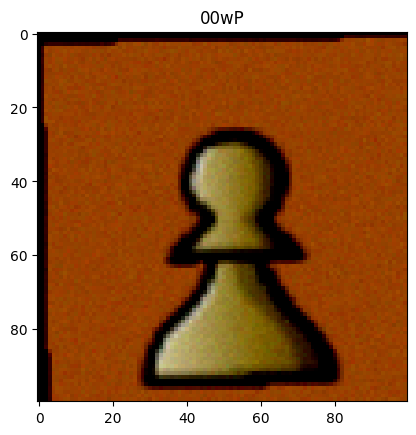

Class index: 1, class name: 01bP


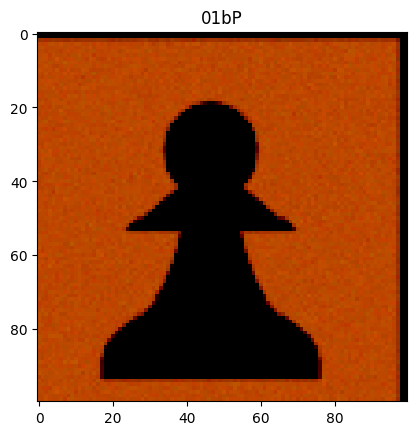

Class index: 2, class name: 02wN


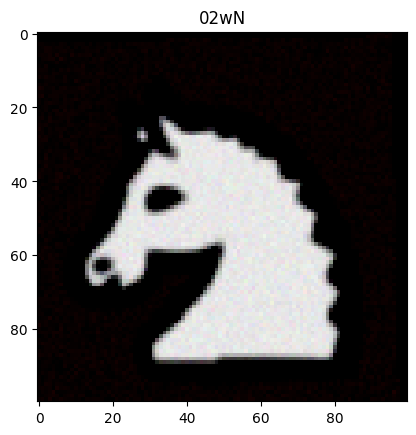

Class index: 3, class name: 03bN


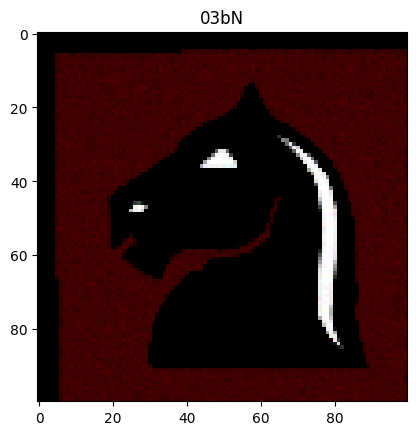

Class index: 4, class name: 04wB


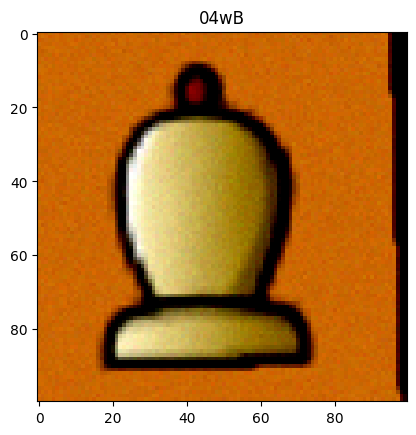

Class index: 5, class name: 05bB


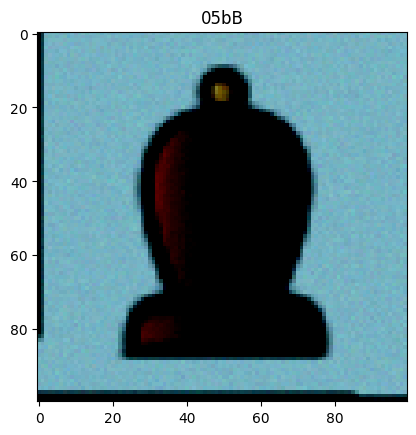

Class index: 6, class name: 06wR


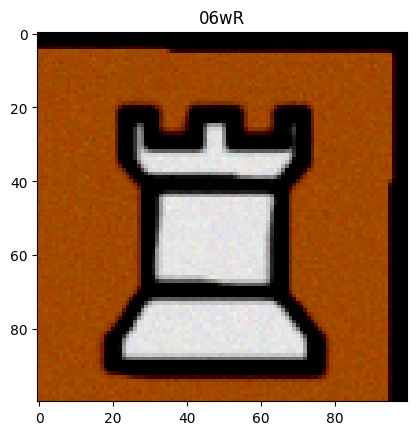

Class index: 7, class name: 07bR


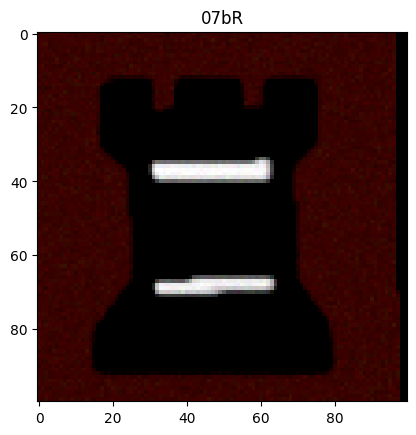

Class index: 8, class name: 08wQ


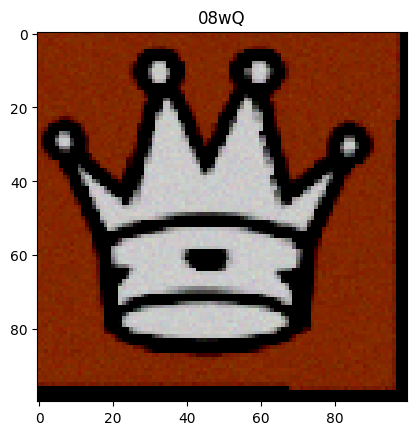

Class index: 9, class name: 09bQ


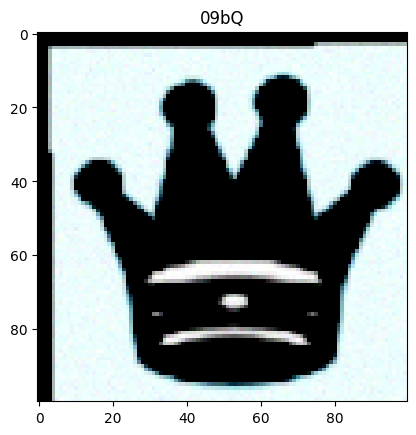

Class index: 10, class name: 10wK


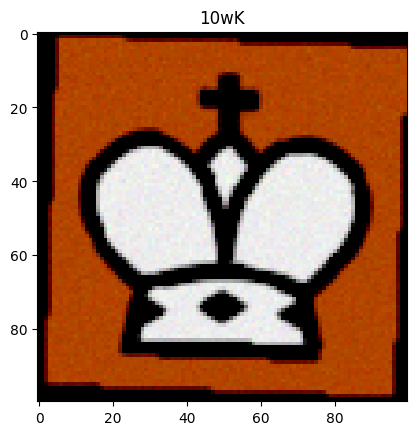

Class index: 11, class name: 11bK


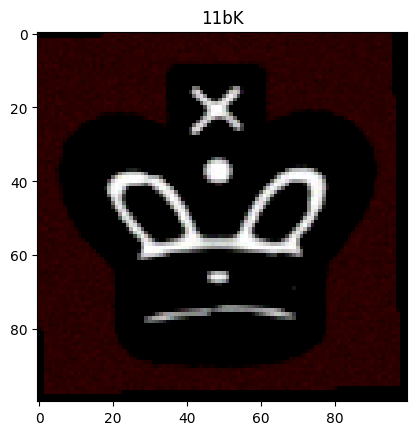

Class index: 12, class name: 12em


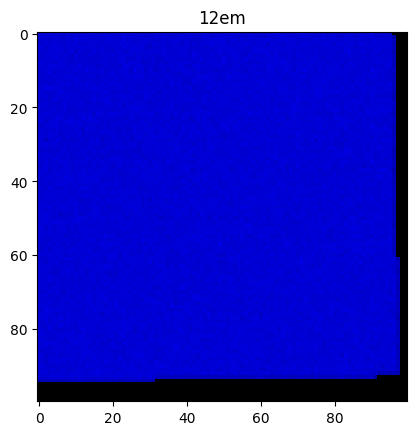

In [ ]:
class AdditiveGaussianNoise(torch.nn.Module):
    def __init__(self, std=0.02):
        super().__init__()
        self.std = std

    def forward(self, x):
        noise = torch.randn_like(x) * self.std
        return x + noise

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=2,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.3, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    AdditiveGaussianNoise(0.02)
])

test_val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    #transforms.Normalize(mean=[mean[0],mean[1],mean[2]],std=[std[0],std[1],std[2]])
])

# Load datasets locally (mounting the drive doesn't do such thing)
!cp -r /content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset /content/dataset
train_root = "/content/dataset/train/"
test_root = "/content/dataset/test/"
train_dataset = datasets.ImageFolder(root=train_root, transform=train_transform)

#checking for misalignments in pair image-target
print("CLASS ORDER FOR TRAIN DATASET:")
print(train_dataset.classes)
print()

for class_name in train_dataset.classes:
    # find first image of this class
    for i, (_, label) in enumerate(train_dataset.samples):
        if train_dataset.classes[label] == class_name:
            img, lbl = train_dataset[i]
            print(f"Class index: {lbl}, class name: {train_dataset.classes[lbl]}")
            plt.imshow(img.permute(1, 2, 0))
            plt.title(f"{class_name}")
            plt.show()
            break

# train_loader = DataLoader(train_dataset, batch_size=math.ceil(len(train_dataset)/10), shuffle=True, num_workers=os.cpu_count(), pin_memory = True, persistent_workers=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory = True, persistent_workers=True)

test_dataset = datasets.ImageFolder(root=test_root, transform=test_val_transform)

#i split the test set into validation and test set, both 10% of the original dataset
random_generator = torch.Generator().manual_seed(50)
val_dataset, test_dataset = random_split(test_dataset, lengths=[0.5,0.5], generator = random_generator)

#test_loader = DataLoader(test_dataset, shuffle=False, num_workers=os.cpu_count(), pin_memory = True, persistent_workers=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64,num_workers=4, pin_memory = True, persistent_workers=True)
#test_loader = DataLoader(test_dataset, shuffle=False, num_workers=0) #if you get problems with DataLoaders PIDs set the "num_workers" to zero and delete the "persistent_workers" parameter)

#val_loader = DataLoader(val_dataset, shuffle=False, num_workers=os.cpu_count(), pin_memory = True, persistent_workers=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers=4, pin_memory = True, persistent_workers=True)

In [2]:
target_names = ["wP","bP",
                "wN","bN",
                "wB","bB",
                "wR","bR",
                "wQ","bQ",
                "wK","bK","em"]

In [ ]:
min = 100
max = -100
for _,(tensor,_) in enumerate(train_dataset):
  temp_min = torch.min(tensor)
  temp_max = torch.max(tensor)
  if temp_min < min: min = temp_min
  if temp_max < max: max = temp_max

print(f"Range of values after normalization: [{temp_min},{temp_max}]")

Range of values after normalization: [-1.0613571405410767,0.29586440324783325]


#Convolutionary Neural Network

## CNN Definition

I used https://www.maplefan.com/conv-pool/ calculator to find the right size for the number of neurons of the first linear fully connected layer.

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # compute flattened size dynamically — avoids mistakes
        # create a dummy image that matches the training images
        test_tensor = torch.zeros(1, 3, 100, 100)
        with torch.no_grad():
            # pass the dummy through the entire convolutional layers
            conv_out = self.conv(test_tensor)

        # obtain the convolution output dimensionality
        flatten_dim = conv_out.numel()

        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # OUT layer (raw logits, no softmax!)
        self.out = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.fc(x)
        x = self.out(x)  # raw logits
        return x

In [4]:
def train(model, train_loader, val_loader, args):
  optimizer = args.optimizer(model.parameters(), lr=args.lr)

  train_losses, val_losses = dict(), dict()
  step = -1
  count = 0
  best_val_loss = float('inf')
  best_model = None

  ### START OF TRAINING
  for epoch in range(args.n_epochs):

    tot_loss = 0
    num_examples = 0
    n_correct = 0

    loading_bar = tqdm(train_loader) #tqdm is a library in Python that provides progress bars for loops and iterables.
    model.train() #sets the model to training mode (instead of evaluation mode)

    ### EPOCH OF TRAINING
    for (X, y) in loading_bar:
      X, y = X.to(args.device), y.to(args.device)
      # classes probability
      prob = model(X)
      # average loss on batch
      loss = args.loss_fn(prob, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      step += 1

      # log step
      tot_loss += loss.item() * X.shape[0] #???
      num_examples += X.shape[0] #???
      running_loss = tot_loss / num_examples #???
      train_losses[step] = running_loss #???

      pred = prob.argmax(-1) #we want to find the index of the maximum element along the last dimension of the tensor. In this case, the last dimension represents the different classes.
      n_correct += sum(pred == y)

      loading_bar.set_description(f'Epoch {epoch+1:<3d} [Loss: {running_loss:.4f}]')
    ### END OF EPOCH OF TRANING

    train_accuracy = n_correct / len(train_dataset)
    val_loss, val_accuracy, _ = evaluate(model, val_loader, args)
    val_losses[step] = val_loss

    print('-'*80)
    print(f'Train accuracy: {train_accuracy:.2%}')
    print(f'Val accuracy:   {val_accuracy:.2%}')
    print(f'Val loss:       {val_loss:.4f}')

    # early stopping
    if val_loss > best_val_loss:
      count += 1
      print(f'===> Patience {count:>3d}/{args.patience:<3d}')
      if count == args.patience:
        break
    else:
      count = 0
      best_val_loss = val_loss
      best_model = model.state_dict()

    print()
  ### END OF TRAINING

  model.load_state_dict(best_model)

  return train_losses, val_losses

In [5]:
def evaluate(model, dataset, args, no_loading_bar=True):
  tot_loss = 0
  n_correct = 0
  preds, target, probs = [], [], []

  model.eval()

  with torch.no_grad():
    for (X, y) in tqdm(dataset, disable=no_loading_bar):
      X, y = X.to(args.device), y.to(args.device)
      prob = model(X)
      pred = prob.argmax(-1)
      loss = args.loss_fn(prob, y)
      n_correct += sum(pred == y)
      tot_loss += loss.item() * X.shape[0]

      probs.append(prob)
      preds.append(pred)
      target.append(y)

  info = {
    'prob': torch.cat(probs),
    'preds': torch.cat(preds),
    'target': torch.cat(target)
  }

  return tot_loss / len(preds), n_correct / len(preds), info #dlen(prebs) == # of elements evaluated

## CNN training

In [ ]:
args = SimpleNamespace(
    loss_fn = nn.CrossEntropyLoss(),
    optimizer = optim.Adam,
    lr = 0.001,
    n_epochs = 100,
    patience = 10,
    device = "cuda" if torch.cuda.is_available() else "cpu",
)

In [ ]:
model = CNN(len(target_names)).to(args.device)
train_losses, val_losses = train(model, train_loader, val_loader, args)

Epoch 1   [Loss: 5.9439]: 100%|██████████| 37/37 [00:06<00:00,  5.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 28.35%
Val accuracy:   4000.00%
Val loss:       69.4625



Epoch 2   [Loss: 1.1766]: 100%|██████████| 37/37 [00:07<00:00,  4.96it/s]


--------------------------------------------------------------------------------
Train accuracy: 58.06%
Val accuracy:   5160.00%
Val loss:       37.7718



Epoch 3   [Loss: 0.7402]: 100%|██████████| 37/37 [00:06<00:00,  6.07it/s]


--------------------------------------------------------------------------------
Train accuracy: 74.13%
Val accuracy:   5930.00%
Val loss:       14.9971



Epoch 4   [Loss: 0.5647]: 100%|██████████| 37/37 [00:07<00:00,  4.89it/s]


--------------------------------------------------------------------------------
Train accuracy: 80.99%
Val accuracy:   5680.00%
Val loss:       17.0812
===> Patience   1/10 



Epoch 5   [Loss: 0.4232]: 100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


--------------------------------------------------------------------------------
Train accuracy: 85.12%
Val accuracy:   5940.00%
Val loss:       9.8614



Epoch 6   [Loss: 0.3597]: 100%|██████████| 37/37 [00:08<00:00,  4.45it/s]


--------------------------------------------------------------------------------
Train accuracy: 87.72%
Val accuracy:   6160.00%
Val loss:       4.9266



Epoch 7   [Loss: 0.2919]: 100%|██████████| 37/37 [00:08<00:00,  4.48it/s]


--------------------------------------------------------------------------------
Train accuracy: 89.94%
Val accuracy:   6140.00%
Val loss:       4.6953



Epoch 8   [Loss: 0.2715]: 100%|██████████| 37/37 [00:08<00:00,  4.57it/s]


--------------------------------------------------------------------------------
Train accuracy: 90.15%
Val accuracy:   6160.00%
Val loss:       4.4322



Epoch 9   [Loss: 0.2602]: 100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


--------------------------------------------------------------------------------
Train accuracy: 90.88%
Val accuracy:   6190.00%
Val loss:       3.0446



Epoch 10  [Loss: 0.2094]: 100%|██████████| 37/37 [00:07<00:00,  5.02it/s]


--------------------------------------------------------------------------------
Train accuracy: 91.77%
Val accuracy:   6250.00%
Val loss:       2.7145



Epoch 11  [Loss: 0.1912]: 100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


--------------------------------------------------------------------------------
Train accuracy: 92.80%
Val accuracy:   6180.00%
Val loss:       3.5760
===> Patience   1/10 



Epoch 12  [Loss: 0.2023]: 100%|██████████| 37/37 [00:07<00:00,  4.95it/s]


--------------------------------------------------------------------------------
Train accuracy: 93.27%
Val accuracy:   6250.00%
Val loss:       2.6204



Epoch 13  [Loss: 0.1807]: 100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


--------------------------------------------------------------------------------
Train accuracy: 93.05%
Val accuracy:   6230.00%
Val loss:       2.1622



Epoch 14  [Loss: 0.1402]: 100%|██████████| 37/37 [00:07<00:00,  4.90it/s]


--------------------------------------------------------------------------------
Train accuracy: 94.84%
Val accuracy:   6270.00%
Val loss:       1.4065



Epoch 15  [Loss: 0.1553]: 100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 94.20%
Val accuracy:   6250.00%
Val loss:       1.8595
===> Patience   1/10 



Epoch 16  [Loss: 0.1380]: 100%|██████████| 37/37 [00:07<00:00,  4.89it/s]


--------------------------------------------------------------------------------
Train accuracy: 94.93%
Val accuracy:   6270.00%
Val loss:       0.9722



Epoch 17  [Loss: 0.1184]: 100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.16%
Val accuracy:   6290.00%
Val loss:       1.0885
===> Patience   1/10 



Epoch 18  [Loss: 0.1443]: 100%|██████████| 37/37 [00:07<00:00,  4.91it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.18%
Val accuracy:   6270.00%
Val loss:       1.5802
===> Patience   2/10 



Epoch 19  [Loss: 0.1200]: 100%|██████████| 37/37 [00:05<00:00,  6.30it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.61%
Val accuracy:   6290.00%
Val loss:       0.9170



Epoch 20  [Loss: 0.0989]: 100%|██████████| 37/37 [00:08<00:00,  4.62it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.08%
Val accuracy:   6320.00%
Val loss:       0.2647



Epoch 21  [Loss: 0.1022]: 100%|██████████| 37/37 [00:05<00:00,  6.27it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.63%
Val accuracy:   6310.00%
Val loss:       0.5158
===> Patience   1/10 



Epoch 22  [Loss: 0.1180]: 100%|██████████| 37/37 [00:07<00:00,  4.94it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.82%
Val accuracy:   6280.00%
Val loss:       0.9217
===> Patience   2/10 



Epoch 23  [Loss: 0.1450]: 100%|██████████| 37/37 [00:05<00:00,  6.38it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.01%
Val accuracy:   6190.00%
Val loss:       4.1882
===> Patience   3/10 



Epoch 24  [Loss: 0.1156]: 100%|██████████| 37/37 [00:07<00:00,  5.06it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.65%
Val accuracy:   6210.00%
Val loss:       2.0083
===> Patience   4/10 



Epoch 25  [Loss: 0.0995]: 100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.76%
Val accuracy:   6310.00%
Val loss:       0.4393
===> Patience   5/10 



Epoch 26  [Loss: 0.0975]: 100%|██████████| 37/37 [00:06<00:00,  5.46it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.59%
Val accuracy:   6300.00%
Val loss:       0.6333
===> Patience   6/10 



Epoch 27  [Loss: 0.1108]: 100%|██████████| 37/37 [00:06<00:00,  5.94it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.99%
Val accuracy:   6290.00%
Val loss:       0.5972
===> Patience   7/10 



Epoch 28  [Loss: 0.1107]: 100%|██████████| 37/37 [00:06<00:00,  5.84it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.16%
Val accuracy:   6320.00%
Val loss:       0.2240



Epoch 29  [Loss: 0.0849]: 100%|██████████| 37/37 [00:06<00:00,  5.53it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.68%
Val accuracy:   6310.00%
Val loss:       0.2918
===> Patience   1/10 



Epoch 30  [Loss: 0.0765]: 100%|██████████| 37/37 [00:05<00:00,  6.47it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.31%
Val accuracy:   6310.00%
Val loss:       0.2727
===> Patience   2/10 



Epoch 31  [Loss: 0.0774]: 100%|██████████| 37/37 [00:07<00:00,  5.23it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.27%
Val accuracy:   6320.00%
Val loss:       0.1912



Epoch 32  [Loss: 0.0810]: 100%|██████████| 37/37 [00:05<00:00,  6.44it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.36%
Val accuracy:   6320.00%
Val loss:       0.0441



Epoch 33  [Loss: 0.0748]: 100%|██████████| 37/37 [00:08<00:00,  4.47it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.40%
Val accuracy:   6320.00%
Val loss:       0.1417
===> Patience   1/10 



Epoch 34  [Loss: 0.0992]: 100%|██████████| 37/37 [00:05<00:00,  6.44it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.10%
Val accuracy:   6310.00%
Val loss:       0.2947
===> Patience   2/10 



Epoch 35  [Loss: 0.0842]: 100%|██████████| 37/37 [00:07<00:00,  5.06it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.10%
Val accuracy:   6320.00%
Val loss:       0.1062
===> Patience   3/10 



Epoch 36  [Loss: 0.0583]: 100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.00%
Val accuracy:   6320.00%
Val loss:       0.0537
===> Patience   4/10 



Epoch 37  [Loss: 0.0858]: 100%|██████████| 37/37 [00:07<00:00,  4.82it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.19%
Val accuracy:   6310.00%
Val loss:       0.4159
===> Patience   5/10 



Epoch 38  [Loss: 0.0676]: 100%|██████████| 37/37 [00:05<00:00,  6.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.61%
Val accuracy:   6320.00%
Val loss:       0.1335
===> Patience   6/10 



Epoch 39  [Loss: 0.0839]: 100%|██████████| 37/37 [00:07<00:00,  4.89it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.14%
Val accuracy:   6310.00%
Val loss:       0.2542
===> Patience   7/10 



Epoch 40  [Loss: 0.0494]: 100%|██████████| 37/37 [00:05<00:00,  6.45it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.95%
Val accuracy:   6320.00%
Val loss:       0.0512
===> Patience   8/10 



Epoch 41  [Loss: 0.0335]: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.68%
Val accuracy:   6320.00%
Val loss:       0.0376



Epoch 42  [Loss: 0.0572]: 100%|██████████| 37/37 [00:05<00:00,  6.46it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.95%
Val accuracy:   6320.00%
Val loss:       0.0385
===> Patience   1/10 



Epoch 43  [Loss: 0.0642]: 100%|██████████| 37/37 [00:07<00:00,  5.15it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.04%
Val accuracy:   6320.00%
Val loss:       0.0833
===> Patience   2/10 



Epoch 44  [Loss: 0.0656]: 100%|██████████| 37/37 [00:05<00:00,  6.31it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.31%
Val accuracy:   6320.00%
Val loss:       0.0898
===> Patience   3/10 



Epoch 45  [Loss: 0.0485]: 100%|██████████| 37/37 [00:07<00:00,  5.27it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.47%
Val accuracy:   6320.00%
Val loss:       0.0703
===> Patience   4/10 



Epoch 46  [Loss: 0.0740]: 100%|██████████| 37/37 [00:05<00:00,  6.25it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.57%
Val accuracy:   6320.00%
Val loss:       0.1278
===> Patience   5/10 



Epoch 47  [Loss: 0.0573]: 100%|██████████| 37/37 [00:06<00:00,  5.69it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.83%
Val accuracy:   6320.00%
Val loss:       0.1467
===> Patience   6/10 



Epoch 48  [Loss: 0.0629]: 100%|██████████| 37/37 [00:06<00:00,  5.69it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.25%
Val accuracy:   6320.00%
Val loss:       0.0581
===> Patience   7/10 



Epoch 49  [Loss: 0.0618]: 100%|██████████| 37/37 [00:06<00:00,  5.87it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.21%
Val accuracy:   6300.00%
Val loss:       0.3366
===> Patience   8/10 



Epoch 50  [Loss: 0.0700]: 100%|██████████| 37/37 [00:06<00:00,  5.48it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.61%
Val accuracy:   6320.00%
Val loss:       0.0212



Epoch 51  [Loss: 0.0731]: 100%|██████████| 37/37 [00:05<00:00,  6.25it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.61%
Val accuracy:   6320.00%
Val loss:       0.0244
===> Patience   1/10 



Epoch 52  [Loss: 0.0595]: 100%|██████████| 37/37 [00:07<00:00,  5.28it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.95%
Val accuracy:   6320.00%
Val loss:       0.0111



Epoch 53  [Loss: 0.0763]: 100%|██████████| 37/37 [00:05<00:00,  6.41it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.23%
Val accuracy:   6320.00%
Val loss:       0.0126
===> Patience   1/10 



Epoch 54  [Loss: 0.0496]: 100%|██████████| 37/37 [00:07<00:00,  4.95it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.25%
Val accuracy:   6320.00%
Val loss:       0.0275
===> Patience   2/10 



Epoch 55  [Loss: 0.0615]: 100%|██████████| 37/37 [00:05<00:00,  6.49it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.78%
Val accuracy:   6320.00%
Val loss:       0.0707
===> Patience   3/10 



Epoch 56  [Loss: 0.0422]: 100%|██████████| 37/37 [00:07<00:00,  4.97it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.34%
Val accuracy:   6320.00%
Val loss:       0.0473
===> Patience   4/10 



Epoch 57  [Loss: 0.0460]: 100%|██████████| 37/37 [00:05<00:00,  6.39it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.21%
Val accuracy:   6320.00%
Val loss:       0.0057



Epoch 58  [Loss: 0.0388]: 100%|██████████| 37/37 [00:07<00:00,  4.92it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.76%
Val accuracy:   6320.00%
Val loss:       0.0188
===> Patience   1/10 



Epoch 59  [Loss: 0.0379]: 100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.81%
Val accuracy:   6320.00%
Val loss:       0.0153
===> Patience   2/10 



Epoch 60  [Loss: 0.0485]: 100%|██████████| 37/37 [00:07<00:00,  4.94it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.21%
Val accuracy:   6310.00%
Val loss:       0.4444
===> Patience   3/10 



Epoch 61  [Loss: 0.0521]: 100%|██████████| 37/37 [00:05<00:00,  6.37it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.21%
Val accuracy:   6320.00%
Val loss:       0.1272
===> Patience   4/10 



Epoch 62  [Loss: 0.0448]: 100%|██████████| 37/37 [00:07<00:00,  4.95it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.47%
Val accuracy:   6320.00%
Val loss:       0.0150
===> Patience   5/10 



Epoch 63  [Loss: 0.0420]: 100%|██████████| 37/37 [00:05<00:00,  6.34it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.64%
Val accuracy:   6320.00%
Val loss:       0.1445
===> Patience   6/10 



Epoch 64  [Loss: 0.0413]: 100%|██████████| 37/37 [00:07<00:00,  5.26it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.64%
Val accuracy:   6320.00%
Val loss:       0.0014



Epoch 65  [Loss: 0.0415]: 100%|██████████| 37/37 [00:06<00:00,  6.06it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.89%
Val accuracy:   6320.00%
Val loss:       0.0178
===> Patience   1/10 



Epoch 66  [Loss: 0.0621]: 100%|██████████| 37/37 [00:06<00:00,  5.51it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.91%
Val accuracy:   6320.00%
Val loss:       0.0143
===> Patience   2/10 



Epoch 67  [Loss: 0.0429]: 100%|██████████| 37/37 [00:06<00:00,  5.79it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.59%
Val accuracy:   6320.00%
Val loss:       0.0370
===> Patience   3/10 



Epoch 68  [Loss: 0.0428]: 100%|██████████| 37/37 [00:06<00:00,  5.79it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.59%
Val accuracy:   6320.00%
Val loss:       0.0063
===> Patience   4/10 



Epoch 69  [Loss: 0.0587]: 100%|██████████| 37/37 [00:06<00:00,  5.59it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.17%
Val accuracy:   6320.00%
Val loss:       0.0196
===> Patience   5/10 



Epoch 70  [Loss: 0.0412]: 100%|██████████| 37/37 [00:05<00:00,  6.31it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.47%
Val accuracy:   6320.00%
Val loss:       0.0044
===> Patience   6/10 



Epoch 71  [Loss: 0.0496]: 100%|██████████| 37/37 [00:07<00:00,  5.19it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.17%
Val accuracy:   6320.00%
Val loss:       0.0298
===> Patience   7/10 



Epoch 72  [Loss: 0.0395]: 100%|██████████| 37/37 [00:05<00:00,  6.32it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.42%
Val accuracy:   6320.00%
Val loss:       0.0601
===> Patience   8/10 



Epoch 73  [Loss: 0.0386]: 100%|██████████| 37/37 [00:07<00:00,  4.93it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.68%
Val accuracy:   6320.00%
Val loss:       0.0152
===> Patience   9/10 



Epoch 74  [Loss: 0.0490]: 100%|██████████| 37/37 [00:05<00:00,  6.43it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.25%
Val accuracy:   6320.00%
Val loss:       0.0183
===> Patience  10/10 


In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/CNN.pth"

torch.save(model.state_dict(), path)

Mounted at /content/gdrive


## CNN testing

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/CNN.pth"

model = CNN(len(target_names)).to(args.device)
model.load_state_dict(torch.load(path))

_, test_accuracy, info = evaluate(model, test_loader, args)

Mounted at /content/gdrive


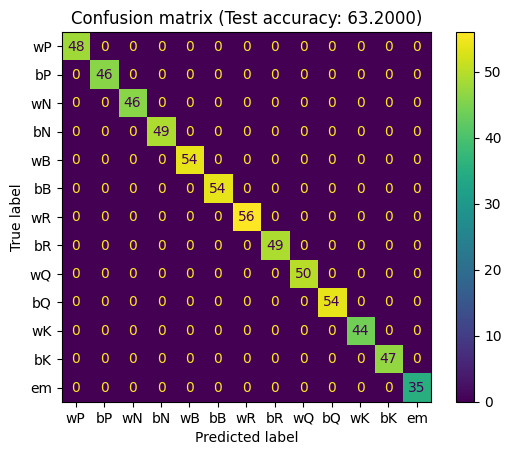

In [ ]:
target, preds = info['target'].cpu(), info['preds'].cpu()
ConfusionMatrixDisplay.from_predictions(target, preds)
plt.title(f'Confusion matrix (Test accuracy: {test_accuracy:.4f})')
plt.gca().set_yticklabels(target_names)
plt.gca().set_xticklabels(target_names)
plt.show()

# Best model test on real life screenshots

## Test screenshots resizing

The first thing i need to do is resize the test screenshots to have dimensionality 640x640, so that the model will still be working on 80x80 single squares.

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Screenshot_Test/"

try:
  #Resized Screenshot test folder
  os.mkdir(f'{path}/Resized_Test/')
except FileExistsError:
    print("Folder already exists!")

for img_name in os.listdir(path):
  img_path = os.path.join(path,img_name)
  if not os.path.isdir(img_path):
    img = cv2.imread(img_path)
    new_dimensions = (800,800)
    resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA) #this type of interpolation tries to keep the quality when upscaling/downscaling
    resized_test_path = os.path.join(path,f"Resized_Test/{img_name}")
    cv2.imwrite(resized_test_path, resized_img) #overwrite the existing images with the resized ones

Mounted at /content/gdrive
Folder already exists!


##Best model loading

In [10]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/CNN.pth"

#Prima avevo queste due righe invece del blocco sotto
# model = CNN(len(target_names)).to(args.device)
# model.load_state_dict(torch.load(path))
args = SimpleNamespace(
    loss_fn = nn.CrossEntropyLoss(),
    optimizer = optim.Adam,
    lr = 0.001,
    n_epochs = 100,
    patience = 10,
    device = "cuda" if torch.cuda.is_available() else "cpu",
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(len(target_names))
model.load_state_dict(torch.load(path, map_location=device))#is GPU available moves the tensors to GPU, CPU otherwise
model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[mean[0],mean[1],mean[2]],std=[std[0],std[1],std[2]])
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
    #transforms.Normalize(mean=mean,std=std)
])

Mounted at /content/gdrive


##8x8 matrix creation and print from screenshot

In [114]:
# return a matrix containing each cell in order (from [0,0] to [7,7])
def cells_from_screenshot(image_path):
    chessboard_row = []
    cont = 0
    image = cv2.imread(image_path)

    #Define the size of the squares
    square_size = 100
    parts = []

    #screenshot split into 64 squares
    for i in range(0, 800, square_size):
      for j in range(0, 800, square_size):
        square = image[i:i + square_size, j:j + square_size]
        parts.append(square)

    image_path = image_path.split("/")[-1]
    print(f"Image: {image_path}")
    fig = plt.figure(figsize=(8, 8))  # Adjust figure size
    grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=.09)

    for ax, img in zip(grid, parts):
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
      ax.axis('off')  # Turn off axis labels

    plt.show()
    return parts

##Fen notation conversion

Fen notation rules:
```
Empty square are indicated with the number of adjacent ones in the row between pieces
Each row ends with a /, except for the last one
Space
w if it's white turn, b otherwise
Space
- if neither side can castle
K if white can castle king side
Q if white can castle queen side
k if black can castle king side
q if black can castle queen side
KQkq if both side can castle
Space
- if no en passant is possible (modern notation checks it automatically)
Number: The number of halfmoves since the last capture or pawn advance, used for the fifty-move rule
Number: The number of the full moves. It starts at 1 and is incremented after Black's move

I'm going to always set the last 3 elements to - 0 1 for simplicity
```
Pieces:
```
r black rook, R white rook
n black knight, N white knight
b black bishop, B white bishop
q black queen, Q white queen
k black king, K white king
p black pawn, P white pawn
```


In [28]:
def fen_notation(piece):
  match piece:
      case "wP":
        return "P"
      case "bP":
        return "p"
      case "wN":
        return "N"
      case "bN":
        return "n"
      case "wB":
        return "B"
      case "bB":
        return "b"
      case "wR":
        return "R"
      case "bR":
        return "r"
      case "wQ":
        return "Q"
      case "bQ":
        return "q"
      case "wK":
        return "K"
      case "bK":
        return "k"

From predictions to FEN

In [111]:
def fen_from_predictions(predictions, additional_info):
  pieces = np.array(predictions[0]).reshape(8,8)
  confidence = np.array(predictions[1]).reshape(8,8)
  fen = ""
  space = " "
  fixed_conclusion = "- 0 1"

  #i create the FEN one row at a time
  for i in range(len(pieces)):
    em_counter = 0
    pieces_row = []
    for j in range(len(pieces[i])):
      #if confidence < threshold then convert the prediction to empty
      if pieces[i][j] == "em" or confidence[i][j]<=.5:
        em_counter += 1
      else:
        if em_counter != 0:
          pieces_row.append(str(em_counter))
          fen = fen + str(em_counter)
          em_counter = 0
        #pieces_row.append((fen_notation(pieces[i][j]),confidence[i][j]))
        pieces_row.append(fen_notation(pieces[i][j]))
        fen = fen + fen_notation(pieces[i][j])
    if em_counter != 0:
      fen = fen + str(em_counter)
      pieces_row.append(str(em_counter))
    if i < 7:
      fen = fen + "/"
    #print(pieces_row)

  if additional_info:
    print("White or black turn?\nw white\nb black")
    fen = fen + space + input() + space
    print("Who can castle ?\n- if neither side can castle\nKQkq if both side can castle\nK if white can castle king side\Q if white can castle queen side\nk if black can castle king side\nq if black can castle queen side")
    fen = fen + input() + space + fixed_conclusion
  #for now let's say that it's always white turn and both side can castle
  else: fen = fen + space + "w" + space + "KQkq" + space + fixed_conclusion
  print(f"\nFEN: {fen}\n")
  return fen


##CNN testing on real life screenshots

In [116]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Screenshot_Test/Resized_Test/"
pieces_path = "/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/fen_to_image"

model.eval()
for img_name in os.listdir(path):
  print("Original chessboard")
  cont = 1
  chessboard = np.array(cells_from_screenshot(os.path.join(path,img_name)))
  pieces_predictions = [[],[]]
  with torch.no_grad():
    for X in chessboard:
      X = transform(X)
      X = X.unsqueeze(0).to(args.device)
      result = model(X)
      prob = torch.softmax(result, dim=1)
      confidence, pred = prob.max(dim=1)
      predicted = target_names[pred.item()]
      #print(f"{cont}) Predicted: {predicted}, confidence: {confidence.item():.4f}")
      cont += 1
      pieces_predictions[0].append(predicted)
      pieces_predictions[1].append(confidence)
  boardImage = fenToImage(fen=fen_from_predictions(pieces_predictions, additional_info=False),
                          squarelength=80,
                          pieceSet=loadPiecesFolder(path=pieces_path, cache=True),
                          darkColor="#D18B47",
                          lightColor="#FFCE9E")
  print("Predicted chessboard")
  display(boardImage)
  print("\n---------------------------------------------------------------------------------------------------\n")

Output hidden; open in https://colab.research.google.com to view.